Dataset: **Sleep-EDF Expanded**  
https://physionet.org/content/sleep-edfx/1.0.0/

필요한 모듈 다운로드 받기

In [10]:
__author__ = "Jeroen Van Der Donckt"

import itertools
import mne
import pyedflib
import pandas as pd

from typing import List, Union, Tuple


def load_signals(
    file_path: str, only_info: bool = False, retrieve_signals: List[str] = None
) -> Union[List, Tuple[List[str], List[float]]]:
    """Load the edf signals for the given filepath.

    Parameters
    ----------
    file_path: str
        The path to the EDF file containing the PSG signals.
    only_info: bool, optional
        Flag that indicates if only info should be returned, i.e., 2 lists; a list
        of the signal names, and a list of the corresponding frequencies. By default
        False.
    retrieve_signals: List[str], optional
        The list of signals to load. If None, than all signals are loaded. By default
        None.

    Returns
    -------
    Union[List, Tuple[List[str], List[float]]]:
        The info (signal names and frequencies) or a list of the loaded signals.

    """
    edf = pyedflib.EdfReader(file_path)
    start = edf.getStartdatetime()
    signals, frequencies = edf.getSignalLabels(), edf.getSampleFrequencies()
    if only_info:
        edf.close()
        return signals, frequencies
    data = []

    for ch_idx, sig_name, freq in zip(
        range(len(signals)),
        signals,
        frequencies,
    ):
        if retrieve_signals is not None and sig_name not in retrieve_signals:
            continue
        sig = edf.readSignal(chn=ch_idx)
        idx = pd.date_range(
            start=start, periods=len(sig), freq=pd.Timedelta(1 / freq, unit="s")
        )
        data += [pd.Series(sig, index=idx, name=sig_name)]
    edf.close()
    return data

def load_annotations(annotation_file_path: str, psg_file_path: str) -> pd.DataFrame:
    """Load the edf+ annotations for the given filepath using pyedflib."""
    # EDF+ 주석 읽기
    edf_ann = pyedflib.EdfReader(annotation_file_path)
    onsets, durations, descriptions = edf_ann.readAnnotations()
    edf_ann.close()

    # PSG 파일에서 시작 시간 가져오기
    start_time = pyedflib.EdfReader(psg_file_path).getStartdatetime()

    # DataFrame 생성
    df = pd.DataFrame({
        "start": [start_time + pd.Timedelta(seconds=o) for o in onsets],
        "end":   [start_time + pd.Timedelta(seconds=o + d) for o, d in zip(onsets, durations)],
        "description": descriptions
    }).set_index("start")

    return df

def annotation_to_30s_labels(annotations: pd.DataFrame) -> pd.DataFrame:
    """Convert the annotations to 30 sec labels."""
    if not (annotations.index[1:] == annotations.end[:-1]).all():
        # There is a gap in the annotations
        diffs = (annotations.index[1:] - annotations.end[:-1]).dt.seconds
        gaps = diffs[diffs != 0]
        # The end time of gap_starts indicate the start of the gap
        gap_starts = annotations[:-1][~(annotations.index[1:] == annotations.end[:-1])]
        # The start time of gap_ends indicate the end of the gap
        gap_ends = annotations[1:][~(annotations.index[1:] == annotations.end[:-1])]
        for idx, gap in enumerate(gaps):
            assert gap > 0
            gap_start_label = gap_starts["description"].values[idx]
            gap_end_label = gap_ends["description"].values[idx]
            if gap_start_label == gap_end_label:
                annotations.loc[
                    annotations.index == gap_starts.index[idx], "end"
                ] += pd.Timedelta(gap, unit="s")
            else:
                print("Cannot fix gap")

    index = pd.date_range(
        start=annotations.index[0], end=annotations.end[-1], freq=pd.Timedelta("30s")
    )
    duration = (annotations.end - annotations.index).dt.seconds.values // 30
    labels = itertools.chain.from_iterable(
        [[l] * d for (l, d) in zip(annotations["description"], duration)]
    )
    df = pd.DataFrame({"label": labels}, index=index[:-1])
    df.index.name = "start"

    return df

In [3]:
!pip install mne pyedflib seglearn tsfel tsfresh antropy plotly-resampler plotly anywidget tsflex yasa
%load_ext autoreload
%autoreload 2

라이브러리 불러오기

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler


# Data loading

## Load some data

=> In total 306 files (153 PSG files - 153 hypnogram files) => 7.1 GB

In [18]:
import os
import pandas as pd

# 데이터가 있는 폴더의 전체 경로 지정
data_folder = "/content/drive/MyDrive/"
sub_folder = "sleep-cassette"

# 전체 파일 경로
full_folder_path = os.path.join(data_folder, sub_folder)

# .edf 파일만 필터링하여 정렬된 리스트 생성
sorted_files = sorted([f for f in os.listdir(full_folder_path) if f.endswith(".edf")])

# PSG 및 Hypnogram 파일이 교대로 저장되어 있다고 가정
psg_hypnogram_files = [(p, h) for p, h in zip(sorted_files[::2], sorted_files[1::2])]

# 데이터 프레임 생성
df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
df_files["subfolder"] = sub_folder

# 환자 ID 추출 (파일 이름의 처음 5글자로 가정)
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f[:5])

# 결과 출력
df_files


,psg_file,label_file,subfolder,patient_id
0,SC4001E0-PSG.edf,SC4001EC-Hypnogram.edf,sleep-cassette,SC400
1,SC4002E0-PSG.edf,SC4002EC-Hypnogram.edf,sleep-cassette,SC400
2,SC4011E0-PSG.edf,SC4011EH-Hypnogram.edf,sleep-cassette,SC401
3,SC4012E0-PSG.edf,SC4012EC-Hypnogram.edf,sleep-cassette,SC401
4,SC4021E0-PSG.edf,SC4021EH-Hypnogram.edf,sleep-cassette,SC402
...,...,...,...,...
148,SC4802G0-PSG.edf,SC4802GV-Hypnogram.edf,sleep-cassette,SC480
149,SC4811G0-PSG.edf,SC4811GG-Hypnogram.edf,sleep-cassette,SC481
150,SC4812G0-PSG.edf,SC4812GV-Hypnogram.edf,sleep-cassette,SC481
151,SC4821G0-PSG.edf,SC4821GC-Hypnogram.edf,sleep-cassette,SC482


In [19]:
paper_patients = [#환자라고 유추되는 시리얼 넘버를 20명 지정하여 모델 평가에 사용 , 나머지 58명도 구분하여 데이터프레임에 저장
    "SC400",
    "SC401",
    "SC402",
    "SC403",
    "SC404",
    "SC405",
    "SC406",
    "SC407",
    "SC408",
    "SC409",
    "SC410",
    "SC411",
    "SC412",
    "SC413",
    "SC414",
    "SC415",
    "SC416",
    "SC417",
    "SC418",
    "SC419",
]


In [20]:
#20명 환자 묶음-논문 기준이라 이렇게 작성
df_files_paper = df_files[df_files.patient_id.isin(paper_patients)]
df_files_paper.psg_file.nunique()

#20명 증명
df_files_paper.patient_id.nunique()



20

In [14]:
#20명 외 나머지 환자 데이터를 데이터프레임에 포함 -58명
df_files_other = df_files[~df_files.patient_id.isin(paper_patients)]
df_files_other.psg_file.nunique()


114

In [15]:
df_files_other.patient_id.nunique()


#신호와 각 신호별 주파수 수치를 확인 + 개수 =>  모두 결측치 없고 수치는 EEG,EEG,EOG가 100, 나머지 1
signal_dict = {}

for idx in range(len(df_files)):
    sig, freq = load_signals(
        data_folder + df_files.iloc[idx].subfolder + "/" + df_files.iloc[idx].psg_file,
        only_info=True,
    )
    for s, f in zip(sig, freq):
        if (s, f) in signal_dict.keys():
            signal_dict[(s, f)].append(idx)
        else:
            signal_dict[(s, f)] = [idx]

# Displays (sig, freq) #recordings
[(k, len(v)) for k, v in signal_dict.items()]


[(('EEG Fpz-Cz', np.float64(100.0)), 153),
 (('EEG Pz-Oz', np.float64(100.0)), 153),
 (('EOG horizontal', np.float64(100.0)), 153),
 (('Resp oro-nasal', np.float64(1.0)), 153),
 (('EMG submental', np.float64(1.0)), 153),
 (('Temp rectal', np.float64(1.0)), 153),
 (('Event marker', np.float64(1.0)), 153)]

In [21]:
common_signals = [
    "EEG Fpz-Cz",
    "EEG Pz-Oz",
    "EOG horizontal",  # All have the same sampling rate (100 Hz)
    "EMG submental",  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]


In [22]:
#데이터 연결하기 위해 신호오하 주석 모두 호출
data = load_signals(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
    retrieve_signals=common_signals,
)
annotations = load_annotations(
    annotation_file_path=data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].label_file,
    psg_file_path=data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file

)


In [23]:
#수면 스코어 카테고리 변수에 담기
cats = [
    "Sleep stage ?",
    "Movement time",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
][::-1]

#1명 인터렉티브 시각화
idxs = [s.name for s in data]

# EDA + pipeline (for 1 patient)

In [ ]:


fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=2_000,
)

for idx, s in enumerate(data, 1):
    fig.add_trace(
        go.Scattergl(
            x=[],
            y=[],
            name=s.name,
            line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.add_trace(
    go.Scattergl(
        x=[],
        y=[],
        name="Hypnogram",
        line_width=1.5,
        line_shape="hv",
    ),
    hf_x=annotation_to_30s_labels(annotations).index,
    hf_y=annotation_to_30s_labels(annotations)["label"].astype("category"),
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=900)
fig.update_yaxes(categoryorder="array", categoryarray=cats)

fig.update_layout(
    legend_traceorder="normal",
    template="plotly_dark",
    #legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8041)


<ipython-input-3-308488835541>:98: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<IPython.core.display.Javascript object>

## Process the signals

In [15]:
## Processing
from scipy.signal import butter, lfilter

from tsflex.processing import SeriesPipeline, SeriesProcessor


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y


# def clipper(sig, min_q=0, max_q=1):
#     return sig.clip(sig.quantile(min_q), sig.quantile(max_q))


eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
    ]
)

process_pipe


[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
]

In [20]:
%%time
#data 전처리 적용
data_processed = process_pipe.process(data, return_all_series=True)

INFO:feature_processing_logger:Finished function [butter_bandpass_filter] on [('EEG Fpz-Cz',), ('EEG Pz-Oz',), ('EOG horizontal',)] with output ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal'] in [0.3622149929999523 seconds]!


CPU times: user 297 ms, sys: 47.8 ms, total: 344 ms
Wall time: 363 ms


In [21]:
#밴드패스 필터 적용한 주파수도 포함하여 시각화(0.4~30만 남기려는 시도)
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.show_dash(port=8041)


NameError: name 'fig' is not defined

## Extract the features

In [16]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [ #푸리에 변환 적용 후 통계값 추가
        {"aggtype": "centroid"},#중심주파수
        {"aggtype": "variance"},#분산
        {"aggtype": "skew"},#비대칭성
        {"aggtype": "kurtosis"},#첨도
    ],
    "fourier_entropy": [
        {"bins": 2},#큰 변화 확인
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},#미세한 변화 확인
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings


{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [ ]:
#시계열적 특성을 추가하기 위해 30 60 90으로 윈도우 크기 조정하는 특성 추출 설계 객체 형성 시도
import antropy as ant
import scipy.stats as ss
from yasa import bandpower

import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x): #히구치 프렉탈 차원 사용 => 뇌파의 복잡도 및 비선형성
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [ # 흔히 쓰는 뇌파 밴드.
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):#위에 정의한 bands에 따라 에너지 계산 후 추출
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [ #통계적 요소 추가
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["hjorth_mobility", "hjorth_complexity"]#신호 복잡도
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs, #시간 기준 특성 추출
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs, #주파수 기준 특성 추출 - EMG 제외(안중요하대요)
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats]) # 특징 추출을 객체로 묶음
print(feature_collection)


EEG Fpz-Cz: (
	win: 30s   : [
		FeatureDescriptor - func: FuncWrapper(std, ['std'], {})    stride: ['30s'],
		FeatureDescriptor - func: FuncWrapper(iqr, ['iqr'], {})    stride: ['30s'],
		FeatureDescriptor - func: FuncWrapper(skew, ['skew'], {})    stride: ['30s'],
		FeatureDescriptor - func: FuncWrapper(kurtosis, ['kurtosis'], {})    stride: ['30s'],
		FeatureDescriptor - func: FuncWrapper(num_zerocross, ['num_zerocross'], {})    stride: ['30s'],
		FeatureDescriptor - func: FuncWrapper(hjorth_params, ['hjorth_mobility', 'hjorth_complexity'], {})    stride: ['30s'],
		FeatureDescriptor - func: FuncWrapper(wrapped_higuchi_fd, ['wrapped_higuchi_fd'], {})    stride: ['30s'],
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['30s'],
		FeatureDescriptor - func: FuncWrapper(perm_entropy, ['perm_entropy'], {})    stride: ['30s'],
		FeatureDescriptor - func: FuncWrapper([tsfresh-combiner_wrapped]__fft_aggregated, ["fft_aggregated_{'aggtype': 'centroid'}", 

In [ ]:
import logging
from tsflex.features.logger import logger
logger.setLevel(level=logging.ERROR)
from tsflex.processing.logger import logger
logger.setLevel(level=logging.ERROR)


In [ ]:
# # %%time -> 코드에서 제공한 피쳐 콜렉션
# feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
# feats


# Pipeline for all patients

In [ ]:
#1차 런타임으로 실행 - 128 인덱스까지 작업
from tqdm.auto import tqdm
import os
import pandas as pd
import glob

# ✅ Google Drive 연동
from google.colab import drive
drive.mount('/content/drive')

# ✅ 저장 경로 설정 (Google Drive 내 원하는 위치 지정)
intermediate_save_path = "/content/drive/MyDrive/sleep_features_checkpoints/"
os.makedirs(intermediate_save_path, exist_ok=True)

# ✅ 데이터 처리 및 저장
df_feats = []
for idx, (sub_folder, psg_file, hypnogram_file) in enumerate(tqdm(
    zip(df_files.subfolder, df_files.psg_file, df_files.label_file),
    total=len(df_files)
)):
    try:
        file_folder = data_folder + sub_folder + "/"

        # 데이터 로드 및 처리
        data = load_signals(file_folder + psg_file)
        data_processed = process_pipe.process(data)

        # 특성 추출
        df_feat = feature_collection.calculate(
            data_processed, return_df=True, window_idx="begin"
        ).astype("float32")

        # hypnogram 로드 및 병합
        annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
        annotations = annotation_to_30s_labels(annotations)
        df_feat = df_feat.merge(annotations, left_index=True, right_index=True)

        # 메타 정보 추가
        df_feat["psg_file"] = psg_file
        df_feat["patient_id"] = psg_file[:5]

        # ✅ 실시간으로 Google Drive에 저장
        save_name = f"{idx:03}_{psg_file.replace('.edf', '')}.parquet"
        save_path = os.path.join(intermediate_save_path, save_name)
        df_feat.to_parquet(save_path)

    except Exception as e:
        print(f"⚠️ Error processing {psg_file}: {e}")


In [ ]:
import os
import pandas as pd
import glob
from tqdm.auto import tqdm

# ✅ Google Drive 연동
from google.colab import drive
drive.mount('/content/drive')

# ✅ 저장 폴더 경로
intermediate_save_path = "/content/drive/MyDrive/sleep_features_checkpoints/"
os.makedirs(intermediate_save_path, exist_ok=True)

# ✅ 이미 저장된 인덱스 확인
existing_files = os.listdir(intermediate_save_path)
existing_indices = sorted([
    int(fname.split("_")[0]) for fname in existing_files if fname.endswith(".parquet")
])

# ✅ 전체 파일 중에서 이미 처리된 인덱스를 제외한 작업 목록 구성
df_feats = []
for idx, (sub_folder, psg_file, hypnogram_file) in enumerate(zip(
    df_files.subfolder, df_files.psg_file, df_files.label_file
)):
    if idx in existing_indices:
        continue  # 이미 처리된 파일은 건너뜀

    print(f"▶ Processing index {idx}: {psg_file}")
    try:
        file_folder = data_folder + sub_folder + "/"

        # 데이터 로드 및 처리
        data = load_signals(file_folder + psg_file)
        data_processed = process_pipe.process(data)

        # 특성 추출
        df_feat = feature_collection.calculate(
            data_processed, return_df=True, window_idx="begin"
        ).astype("float32")

        # 라벨 병합
        annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
        annotations = annotation_to_30s_labels(annotations)
        df_feat = df_feat.merge(annotations, left_index=True, right_index=True)

        # 메타 정보 추가
        df_feat["psg_file"] = psg_file
        df_feat["patient_id"] = psg_file[:5]

        # ✅ Google Drive에 실시간 저장
        save_name = f"{idx:03}_{psg_file.replace('.edf', '')}.parquet"
        save_path = os.path.join(intermediate_save_path, save_name)
        df_feat.to_parquet(save_path)

    except Exception as e:
        print(f"⚠️ Error processing index {idx} ({psg_file}): {e}")


In [ ]:
# 저장된 parquet 파일들 병합
df_feats_files = glob.glob(intermediate_save_path + "*.parquet")
df_feats = pd.concat([pd.read_parquet(f) for f in df_feats_files])

# 라벨 컬럼 이름 정리
df_feats.rename(columns={"description": "label"}, inplace=True)


In [ ]:
from tqdm.auto import tqdm
#모든 환자에게 위에서 적용한 과정을 모두 적용하고, hypogram도 합침

df_feats = []
for sub_folder, psg_file, hypnogram_file in tqdm(
    zip(df_files.subfolder, df_files.psg_file, df_files.label_file)
):
    file_folder = data_folder + sub_folder + "/"
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file)
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name & folder
    df_feat["psg_file"] = psg_file
    df_feat["patient_id"] = psg_file[:5]
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

In [ ]:
df_feats.to_parquet("/content/drive/MyDrive/sleep-edf__cassette_features_ALL__90s.parquet")


## Load data

In [1]:
import pandas as pd

In [24]:
df_feats = pd.read_parquet("/content/drive/MyDrive/sleep-edf__cassette_features_ALL__90s.parquet")
df_feats.shape

(416271, 366)

In [3]:
df_feats["label"].value_counts()

,count
label,
Sleep stage W,285286
Sleep stage 2,69132
Sleep stage R,25835
Sleep stage 1,21521
Sleep stage 3,8793
Sleep stage 4,4246
Sleep stage ?,1330
Movement time,128


In [19]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416271 entries, 1989-04-24 16:13:00 to 1991-09-27 14:24:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to patient_id
dtypes: float32(363), object(3)
memory usage: 589.1+ MB


지표 이름	의미	해석

*   fdelta+theta	빠른 델타 + 세타	주로 깊은 수면(Non-REM)에서 증가

* alpha/theta	각성도 지표	깨어 있을수록 알파가 많고, 졸릴수록 세타가 많아짐


* delta/beta	각성 대 수면 비율	많이 쓰이는 수면 깊이 지표
* delta/sigma	깊은 수면 vs 수면 방추	N3(깊은 수면) vs N2(수면 유지) 비교
* delta/theta	델타 우세 여부	전반적인 수면 깊이 반영

In [25]:
common_signals = [
    "EEG Fpz-Cz",
    "EEG Pz-Oz",
    "EOG horizontal",  # All have the same sampling rate (100 Hz)
    "EMG submental",  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]

eeg_signals = [d for d in common_signals if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [
        c
        for c in df_feats.columns
        if c.startswith(eeg_sig) and c.split("__")[1] in bands
    ]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = (
            df_feats["__".join([eeg_sig, "sdelta", window])]
            + df_feats["__".join([eeg_sig, "fdelta", window])]
        )
        fdelta_theta = (
            df_feats["__".join([eeg_sig, "fdelta", window])]
            + df_feats["__".join([eeg_sig, "theta", window])]
        )
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype(
            "float32"
        )

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype(
            "float32"
        )
df_feats.shape #지표 추가후의 개수 확인

(416271, 396)

In [26]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [27]:
#맥락 추가를 위한 블록
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if "w=1m_" in f]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(2).add_suffix("_shift=1m"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"),
        left_index=True,
        right_index=True,
    )
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape


131 0 131


(416271, 920)

In [23]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416271 entries, 1989-04-24 16:13:00 to 1991-09-27 14:24:00
Columns: 920 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to EEG Pz-Oz__delta/theta__w=30s_shift=-1m
dtypes: float32(917), object(3)
memory usage: 1.4+ GB


In [28]:
# 구분이 애매한 스테이디 4와 그냥 라벨을 3으로 정리
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"] # 수면상태 정확히 몰라서 제거
df_feats = df_feats[
    df_feats["label"] != "Sleep stage ?"
]  # Label that is given when recording is done / end of the night


In [29]:
df_feats_paper = df_feats[df_feats.psg_file.isin(df_files_paper.psg_file)]
df_feats_paper.shape


(106377, 920)

In [30]:
import numpy as np
def get_repeat_length(val, arr):
    assert arr[0] == val
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats_paper["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_paper = pd.concat(dfs)
del dfs


In [31]:
def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_all = pd.concat(dfs)
del dfs


Prepare training data for SleepEDF-20

In [32]:
# Subset of data that does not contain the SC-EDF-20 patients
df_feats_trimmed = df_feats_trimmed_all[
    ~df_feats_trimmed_all.psg_file.isin(df_feats_trimmed_paper.psg_file.unique())
]
df_feats_trimmed.shape


(152938, 920)

In [33]:
# Subset of data that does not contain the SC-EDF-20 patients
df_feats_trimmed = df_feats_trimmed_all[
    ~df_feats_trimmed_all.psg_file.isin(df_feats_trimmed_paper.psg_file.unique())
]
df_feats_trimmed.shape


(152938, 920)

In [34]:
any(
    [
        psg_file in df_feats_trimmed_paper.psg_file.unique()
        for psg_file in df_feats_trimmed
    ]
)


False

In [35]:
# Label stats for the SC-EDF-78 \ SC-EDF20 data
df_feats_trimmed["label"].value_counts()


,count
label,
Sleep stage W,57435
Sleep stage 2,51333
Sleep stage 1,18716
Sleep stage R,18118
Sleep stage 3,7336


In [36]:
# Label stats for the SC-EDF-20 data
print(len(df_feats_trimmed_paper))
df_feats_trimmed_paper["label"].value_counts()


42230


,count
label,
Sleep stage 2,17799
Sleep stage W,8207
Sleep stage R,7717
Sleep stage 3,5703
Sleep stage 1,2804


Matches with the samples from other papers

In [37]:
# Label stats for the SC-EDF-78 data
print(len(df_feats_trimmed_all))
df_feats_trimmed_all["label"].value_counts()


195168


,count
label,
Sleep stage 2,69132
Sleep stage W,65642
Sleep stage R,25835
Sleep stage 1,21520
Sleep stage 3,13039


The trimmed wake value count now matches (roughly) the amount of the IITNet & DeepSleepNet paper

### Look into nan features

In [38]:
no_shift_cols = [c for c in df_feats_trimmed_all.columns if not "shift=" in c]# or "w=1m" in c or "w=1m30s" in c]
len(no_shift_cols)

265

In [39]:
normal_nan_mask = (df_feats_trimmed_all[no_shift_cols].isna().sum() / df_feats_trimmed_all.psg_file.nunique()).isin([0, 1, 2])
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().sum().sort_values()[::-1]

,0
EMG submental__wrapped_higuchi_fd__w=30s,160
EMG submental__hjorth_complexity__w=30s,160
EMG submental__fft_aggregated_{'aggtype': 'skew'}__w=30s,160
EMG submental__fft_aggregated_{'aggtype': 'kurtosis'}__w=30s,160
EMG submental__kurtosis__w=30s,91
EMG submental__skew__w=30s,91
EMG submental__hjorth_mobility__w=30s,57
EMG submental__fourier_entropy_{'bins': 60}__w=30s,57
EMG submental__fourier_entropy_{'bins': 3}__w=30s,57
EMG submental__fourier_entropy_{'bins': 5}__w=30s,57


In [40]:
df_feats_trimmed_all["psg_file"][df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1)].value_counts()

,count
psg_file,
SC4731E0-PSG.edf,64
SC4762E0-PSG.edf,48
SC4332F0-PSG.edf,44
SC4771G0-PSG.edf,4


In [41]:
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1).sum() / len(df_feats_trimmed_all)

np.float64(0.0008198065256599442)

=> 0.082% of the feature vectors contain some nan value

*Further findings*: more in depth analysis revealed that the nan values stem from artefacts in the EMG signal (mostly occuring at the beginning and/or end of the sleep period). These signal artefacts induce nan values as some features have the following error *"invalid value encountered in double_scalars"* (possibly due to division by zero).

**What to do with this?**  
For the sake of simplicity we will keep those feature vectors and just (simply) impute the nan values as
* only 0.082% of the feature vectors (i.e., samples) is affected -> will have minimal / no impact on results
* other work did not perform artefact removal -> we will include these samples as this allows a "fair" comparison

## EDA on labels

<Axes: xlabel='label'>

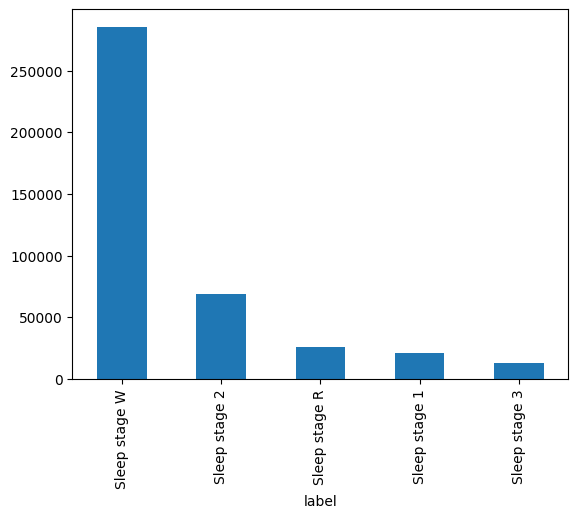

In [37]:
df_feats["label"].value_counts().plot(kind="bar")


<Axes: xlabel='label'>

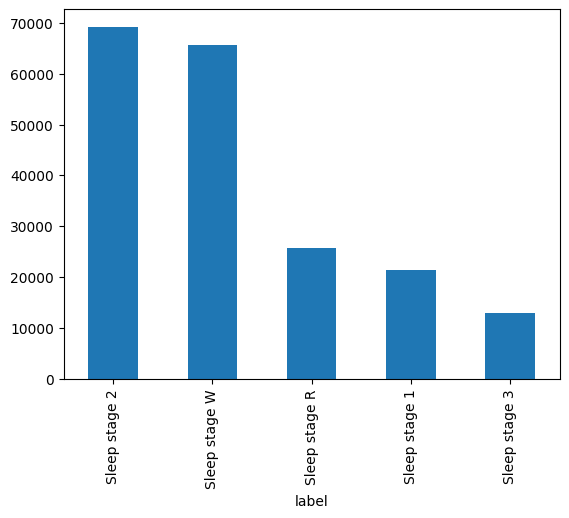

In [ ]:
df_feats_trimmed_all["label"].value_counts().plot(kind="bar")


In [38]:
df_feats_trimmed_all["label"].value_counts()


,count
label,
Sleep stage 2,69132
Sleep stage W,65642
Sleep stage R,25835
Sleep stage 1,21520
Sleep stage 3,13039


=> There is quite some label imbalance

## EDA on features

In [44]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]


In [44]:
import math

import matplotlib.pyplot as plt

plot_cols = [c for c in feat_cols if not "_shift=" in c]

n_cols = 10
n_rows = math.ceil(len(plot_cols) / n_cols)
plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

for idx, col in enumerate(plot_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.boxplot(df_feats_trimmed_all[col].dropna(), vert=True)
    plt.xlabel(col)

plt.tight_layout()
plt.show()


# ML

In [42]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer


## The simple, catboost pipeline

In [37]:
!pip install catboost

In [47]:
### Create pipeline
from catboost import CatBoostClassifier
pipe = CatBoostClassifier(verbose=0, depth=5, n_estimators=2_000, random_state=0)

## Catboost model for SC-20

### Direct transfer from other 58 patients (114 PSGs) to SC-20

* Train & validatie on all patients except the SC-20 patients (i.e., patient_id > 19)
* Test the trained model on those 20 patients (i.e., patient_id in [0-19])

In [48]:
### Fit the pipeline
pipe.fit(df_feats_trimmed[feat_cols], df_feats_trimmed["label"])

In [49]:
# 모델 저장
pipe.save_model("/content/drive/MyDrive/Colab Notebooks/catboost_model.cbm")


In [43]:
df_feats_trimmed[feat_cols]

,EEG Fpz-Cz__TotalAbsPow__w=1m,EEG Fpz-Cz__TotalAbsPow__w=30s,EEG Fpz-Cz__alpha__w=1m,EEG Fpz-Cz__alpha__w=30s,EEG Fpz-Cz__beta__w=1m,EEG Fpz-Cz__beta__w=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 30}__w=1m,EEG Fpz-Cz__binned_entropy_{'max_bins': 30}__w=30s,...,EEG Fpz-Cz__fdelta+theta__w=30s_shift=-1m,EEG Fpz-Cz__alpha/theta__w=30s_shift=-1m,EEG Fpz-Cz__delta/beta__w=30s_shift=-1m,EEG Fpz-Cz__delta/sigma__w=30s_shift=-1m,EEG Fpz-Cz__delta/theta__w=30s_shift=-1m,EEG Pz-Oz__fdelta+theta__w=30s_shift=-1m,EEG Pz-Oz__alpha/theta__w=30s_shift=-1m,EEG Pz-Oz__delta/beta__w=30s_shift=-1m,EEG Pz-Oz__delta/sigma__w=30s_shift=-1m,EEG Pz-Oz__delta/theta__w=30s_shift=-1m
1989-05-08 22:51:00,396.025085,587.047913,0.014803,0.012530,0.021414,0.015518,1.520288,1.844269,2.582881,2.926370,...,0.619964,0.201466,51.090321,132.929794,13.415426,0.416961,0.862715,2.139859,4.956008,4.822725
1989-05-08 22:51:30,330.605560,306.297516,0.015837,0.016410,0.024522,0.028910,1.371135,1.377549,2.408102,2.418226,...,0.653285,0.188491,58.536102,133.175064,12.040922,0.438647,0.848349,2.776655,9.333507,8.597504
1989-05-08 22:52:00,594.307373,451.370483,0.013408,0.013449,0.015802,0.017528,1.608175,1.592463,2.678242,2.649278,...,0.538650,0.129713,41.679306,110.051125,7.088036,0.392115,0.689260,0.969571,2.964329,1.636162
1989-05-08 22:52:30,813.892761,776.567078,0.014091,0.013936,0.016464,0.015208,1.424225,1.771713,2.471243,2.846606,...,0.713618,0.181292,34.076706,110.111946,11.649574,0.426239,0.638447,1.148401,5.006059,2.795331
1989-05-08 22:53:00,766.006409,808.891479,0.012698,0.015347,0.019868,0.020120,1.424739,1.500419,2.474545,2.550885,...,0.633157,0.281704,68.094978,151.311447,14.271687,0.343432,1.673908,2.025450,7.024129,9.170844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-09-27 08:32:00,1477.151001,1261.899048,0.011446,0.013817,0.007196,0.008312,1.567011,1.504436,2.628493,2.548786,...,0.503919,0.194082,74.442841,145.037903,10.584585,0.350175,1.069542,1.315464,3.851942,2.437630
1991-09-27 08:32:30,1401.300293,1643.238770,0.012572,0.010961,0.007934,0.006466,1.634969,1.713335,2.708069,2.786789,...,0.547995,0.259263,52.432835,79.244598,11.038139,0.342226,1.101527,3.596034,6.299797,5.756842
1991-09-27 08:33:00,1217.731079,1027.336426,0.018028,0.016182,0.012630,0.011855,1.654280,1.578821,2.724496,2.647605,...,0.550096,0.361460,14.198575,39.634785,7.269318,0.413782,0.711137,3.774890,8.404506,4.839629
1991-09-27 08:33:30,1285.531128,1350.605103,0.027052,0.020500,0.026087,0.016646,1.530672,1.764113,2.591244,2.838235,...,0.553987,0.207816,53.309650,101.754829,10.032982,0.389310,0.628869,3.097141,8.152524,4.069178


In [ ]:
from catboost import CatBoostClassifier, Pool
import shap
import pandas as pd

# 1. 모델 불러오기
pipe_loaded = CatBoostClassifier()
pipe_loaded.load_model("/content/drive/MyDrive/Colab Notebooks/catboost_model.cbm")

# 2. 데이터 준비 (Pool 형식 필요)
data_pool = Pool(data=df_feats_trimmed[feat_cols], label=df_feats_trimmed["label"])

# 3. SHAP 값 계산
shap_values = pipe_loaded.get_feature_importance(
    type='ShapValues',
    data=data_pool
)

# 4. Summary Plot (SHAP 값에는 마지막 column이 expected_value로 포함되므로 제외 필요)
shap.summary_plot(shap_values[:, :-1], df_feats_trimmed[feat_cols])


In [ ]:
import matplotlib.pyplot as plt

# SHAP 값 계산 (위에서 계산된 shap_values를 사용)
# shap_values는 shap.Explanation 객체여야 합니다

for feature_name in df_feats_trimmed[feat_cols].columns:
    shap.plots.scatter(
        shap_values[:, feature_name],
        color=shap_values,
        show=False  # show=False로 설정 후 직접 plt.show() 호출
    )
    plt.title(f"SHAP Scatter Plot: {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("SHAP value")
    plt.tight_layout()
    plt.show()
import matplotlib.pyplot as plt

# SHAP 값 계산 (위에서 계산된 shap_values를 사용)
# shap_values는 shap.Explanation 객체여야 합니다

for feature_name in df_feats_trimmed[feat_cols].columns:
    shap.plots.scatter(
        shap_values[:, feature_name],
        color=shap_values,
        show=False  # show=False로 설정 후 직접 plt.show() 호출
    )
    plt.title(f"SHAP Scatter Plot: {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("SHAP value")
    plt.tight_layout()
    plt.show()


In [ ]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed["label"], y_pred=preds))

In [ ]:
print("Testing data:")
preds = pipe.predict(df_feats_trimmed_paper[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_paper[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_paper["label"], y_pred=preds))

In [ ]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))


In [ ]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=True, ax=ax)

In [ ]:
import joblib
joblib.dump(pipe, "../models/catboost_DT_SC-20.pkl")

In [ ]:
# cv = StratifiedGroupKFold(n_splits=10).split(
#     df_feats_trimmed[feat_cols],
#     df_feats_trimmed["label"],
#     groups=df_feats_trimmed.patient_id,
# )
# _ = plot_learning_curve(
#     pipe,
#     title="Learning curve - F1 Macro",
#     X=df_feats_trimmed[feat_cols],
#     y=df_feats_trimmed["label"],
#     cv=cv,
#     scoring="f1_macro",
#     n_jobs=25,
#     train_sizes=[0.05] + list(np.linspace(0.1,1,10))
# )


### Grouped X-fold on SC-20

In [ ]:
# Total of 20 folds
gkfold = GroupKFold(n_splits=20)
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_paper[feat_cols],
    df_feats_trimmed_paper["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    # n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [ ]:
print("20-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

In [ ]:
print("20-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


In [ ]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_paper[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_paper["label"].iloc[train_idx]
    X_test = df_feats_trimmed_paper[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_paper["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test).ravel()]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [ ]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

In [ ]:
print(classification_report(preds, y_trues))

In [ ]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

In [ ]:
# cv = StratifiedGroupKFold(n_splits=10).split(
#     df_feats_trimmed_paper[feat_cols],
#     df_feats_trimmed_paper["label"],
#     groups=df_feats_trimmed_paper.patient_id,
# )
# _ = plot_learning_curve(
#     pipe,
#     title="Learning curve - F1 Macro",
#     X=df_feats_trimmed_paper[feat_cols],
#     y=df_feats_trimmed_paper["label"],
#     cv=cv,
#     scoring="f1_macro",
#     n_jobs=20,
#     train_sizes=[0.05] + list(np.linspace(0.1,1,10))
# )


## Catboost model for SC-78

### Grouped X-fold on all 78 patients (153 PSGs)

In [ ]:
# Total of 10 folds
gkfold = StratifiedGroupKFold(n_splits=10)
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_all[feat_cols],
    df_feats_trimmed_all["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    # n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [ ]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))


In [ ]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


In [ ]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats_trimmed_all, df_feats_trimmed_all["label"], groups=df_feats_trimmed_all.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_all[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_all["label"].iloc[train_idx]
    X_test = df_feats_trimmed_all[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_all["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test).ravel()]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [ ]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

In [ ]:
print(classification_report(preds, y_trues))

In [ ]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

In [ ]:
shap ? -> !

In [ ]:
# cv = gkfold.split(
#     df_feats_trimmed_all[feat_cols],
#     df_feats_trimmed_all["label"],
#     groups=df_feats_trimmed_all.patient_id,
# )
# _ = plot_learning_curve(
#     pipe,
#     title="Learning curve - F1 Macro",
#     X=df_feats_trimmed_all[feat_cols],
#     y=df_feats_trimmed_all["label"],
#     cv=cv,
#     scoring="f1_macro",
#     n_jobs=20,
# )